**Imports**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter

In [2]:
import os
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch.optim as optim

**Load the file path**

In [4]:
image_path = '/Users/karthik/GANS/4by4-TOPO-24X224/bio_materials/Pattern_FeatureIdx_1002_TopoUnit_4X4.png'

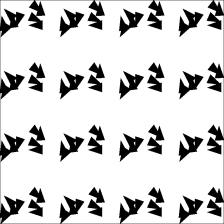

In [5]:
with Image.open(image_path) as img:
    display(img)

In [6]:
path = '/Users/karthik/GANS/4by4-TOPO-24X224/bio_materials/'

img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+ '/' +img)
        
print('Images: ',len(img_names))

Images:  2176


In [7]:
img_sizes = []

rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
            
    except:
        rejected.append(item) 

In [8]:
print(len(img_sizes))

2176


In [9]:
df = pd.DataFrame(img_sizes)

In [10]:
df.head()

,0,1
0,224,224
1,224,224
2,224,224
3,224,224
4,224,224


In [11]:
df.describe()

,0,1
count,2176.0,2176.0
mean,224.0,224.0
std,0.0,0.0
min,224.0,224.0
25%,224.0,224.0
50%,224.0,224.0
75%,224.0,224.0
max,224.0,224.0


**Residual Block**

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

**Constructing the Discriminator**

In [13]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()

        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            self._block(features_d, features_d * 2, 4, 2, 1),
            ResidualBlock(features_d * 2),

            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            ResidualBlock(features_d * 4),

            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            ResidualBlock(features_d * 8),

            self._block(features_d * 8, features_d * 16, 4, 2, 1),
            ResidualBlock(features_d * 16),

            self._block(features_d * 16, features_d * 32, 4, 2, 1),
            ResidualBlock(features_d * 32),
            
            nn.Conv2d(features_d * 32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)

    def forward(self, x):
        for layer in self.disc:
            x = layer(x)
            print("Layer output size:", x.shape)  # Debugging print
        return x
    
channels_img = 1  
features_d = 64
disc = Discriminator(channels_img, features_d)

dummy_input = torch.randn(1, channels_img, 128, 128)  
output = disc(dummy_input)

**Constructing the Generator**

In [14]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(
            # Start with a 4x4 image
            self._block(z_dim, features_g * 16, 4, 1, 0), 
            ResidualBlock(features_g * 16),
            # Upsample to 8x8
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            ResidualBlock(features_g * 8),
            # Upsample to 16x16
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            ResidualBlock(features_g * 4),
            # Upsample to 32x32
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            ResidualBlock(features_g * 2),
            # Upsample to 64x64
            self._block(features_g * 2, features_g, 4, 2, 1),  
            ResidualBlock(features_g),
            # Upsample to 128x128
            self._block(features_g, features_g // 2, 4, 2, 1),
            ResidualBlock(features_g // 2),
            # Upsample to 256x256
            nn.ConvTranspose2d(features_g // 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)            
        )   
    
    def forward(self, x):
        return self.gen(x)

    def forward(self, x):
        for layer in self.gen:
            x = layer(x)
            print("Layer output size:", x.shape)  # Debugging print
        return x
    
z_dim = 112 
channels_img = 1  
features_g = 64
gen = Generator(z_dim, channels_img, features_g)

test_input = torch.randn(1, z_dim, 1, 1)  
output = gen(test_input) 
    
    


**Initialising the weights**

In [15]:
def initialize_weights(model):
    
    for m in model.modules():
        if isinstance(m,(nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

**Parameters**

In [16]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 64
IMAGE_SIZE = 256
CHANNELS_IMG = 1

Z_DIM = 112
NUM_EPOCHS = 30
FEATURES_DISC = 64
FEATURES_GEN = 64

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Initialising the weights**

In [18]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

**Optimiser**

In [19]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [20]:
transforms = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]
)

In [21]:
torch.manual_seed(42)

root = '/Users/karthik/GANS/4by4-TOPO-24X224'
print(os.path.exists(root))

True


In [22]:
import shutil

class_dir = os.path.join(root, 'bio_materials')
os.makedirs(class_dir, exist_ok=True)

for entry in os.scandir(root):
    if entry.is_file() and entry.name.endswith('.png'):  
        shutil.move(entry.path, class_dir)


train_data = datasets.ImageFolder(root, transform=transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [23]:
for images, labels in train_loader:
    break

In [24]:
images.shape

torch.Size([64, 1, 256, 256])

In [25]:
fixed_noise = torch.randn(16, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

In [ ]:
for epoch in range(NUM_EPOCHS):

    for batch_idx, (real, _) in enumerate(train_loader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 17 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(train_loader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 16 examples
                img_grid_real = torchvision.utils.make_grid(real[:16], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:16], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

Epoch [0/30] Batch 0/34                   Loss D: 0.7005, loss G: 1.3860
Epoch [0/30] Batch 17/34                   Loss D: 0.0057, loss G: 5.3948
Epoch [1/30] Batch 0/34                   Loss D: 0.0024, loss G: 6.1719
Epoch [1/30] Batch 17/34                   Loss D: 0.0018, loss G: 6.7892
Epoch [2/30] Batch 0/34                   Loss D: 0.0008, loss G: 7.2079
Epoch [2/30] Batch 17/34                   Loss D: 0.0008, loss G: 7.3404
Epoch [3/30] Batch 0/34                   Loss D: 0.0005, loss G: 7.5988
Epoch [3/30] Batch 17/34                   Loss D: 0.0004, loss G: 7.8250
Epoch [4/30] Batch 0/34                   Loss D: 0.0003, loss G: 8.0972
Epoch [4/30] Batch 17/34                   Loss D: 0.6706, loss G: 0.7226
Epoch [5/30] Batch 0/34                   Loss D: 0.6827, loss G: 0.7241
Epoch [5/30] Batch 17/34                   Loss D: 0.6888, loss G: 0.7116
Epoch [6/30] Batch 0/34                   Loss D: 0.6838, loss G: 0.7310
Epoch [6/30] Batch 17/34                   Lo

https://github.com/Moeinh77/Simpson-face-generator-DCGAN-pytorch/blob/master/GAN%20pytorch.ipynb